# Variational Inference with `jax` and `numpyro`

We will now use `numpyro` to compute the posterior distribution over the parameters of
our Lotka-Volterra model, assuming noisy observations of the time series.

In [8]:
from functools import partial
from pathlib import Path

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax

from flax import struct
from jax import random

from matplotlib.patches import Patch
from numpyro.handlers import replay, seed, substitute, trace
from numpyro.infer import SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer.elbo import ELBO
from numpyro.util import check_model_guide_match
from tqdm import tqdm

# This is a macrocosm-specific plotting setup - it can be installed with `pip install macrocosm-visual`
# or simply commented out
from macrocosm_visual.viz_setup import setup_matplotlib

from macrocosm_visual.viz_setup import setup_matplotlib, setup_plotly
setup_matplotlib("./visual_configs.yaml")
setup_matplotlib("./visual_configs.yaml")

In [9]:
# Defining the Lotka-Volterra model


# This is just like the previous notebook!
@struct.dataclass
class LotkaVolterraParams:
    """
    Parameters for the Lotka-Volterra model.

    alpha: Growth rate of prey
    beta: Predation rate
    gamma: Death rate of predators
    delta: Growth rate of predators
    """

    alpha: float
    beta: float
    gamma: float
    delta: float


def lotka_volterra(
    x0: float,
    y0: float,
    params: LotkaVolterraParams,
    dt: float = 0.01,
    n_steps: int = 100,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Solve the Lotka-Volterra ODEs using Euler's method.

    JAX implementation details:
    - Uses jax.lax.scan for efficient looping (avoids Python loops)
    - scan automatically handles the carry state and accumulates outputs
    - All operations use JAX arrays for automatic differentiation

    Args:
        x0, y0: Initial populations
        params: LotkaVolterraParams instance
        dt: Integration time step
        n_steps: Number of integration steps

    Returns:
        x, y: Time series arrays including initial conditions
    """

    def euler_step(state, _):
        """
        One step of the Euler method.
        """
        x, y = state

        # Lotka-Volterra equations
        dx = dt * (params.alpha * x - params.beta * x * y)
        dy = dt * (params.delta * x * y - params.gamma * y)

        # Update state
        new_state = (x + dx, y + dy)

        # Return new state and the same state (for accumulation)
        return new_state, new_state

    initial_state = (x0, y0)

    # scan efficiently loops and accumulates results; much faster than a Python loop
    _, trajectory = jax.lax.scan(euler_step, initial_state, None, length=n_steps)

    # Unpack trajectory and prepend initial condition
    x_traj, y_traj = trajectory
    x = jnp.concatenate([jnp.array([x0]), x_traj])
    y = jnp.concatenate([jnp.array([y0]), y_traj])

    return x, y


def generate_data(
    x_0: float,
    y_0: float,
    obs_noise_sigma: float,
    true_params: dict,
    n_time_steps: int = 500,
    dt: float = 0.01,
):
    """
    Generate synthetic Lotka-Volterra time series data, adding Gaussian observation noise.

    This function produces a "true" prey and predator trajectory from exact Lotka-Volterra dynamics, 
    then adds independent Gaussian noise to each time point of both species to simulate noisy observations
    (as in real-world scenarios).

    Args:
        x_0 (float): Initial prey population.
        y_0 (float): Initial predator population.
        obs_noise_sigma (float): Standard deviation of the Gaussian observation noise added to each timepoint.
        true_params (dict): Dictionary of ground-truth Lotka-Volterra parameters {alpha, beta, gamma, delta}.
        n_time_steps (int, optional): Number of ODE integration steps (length of trajectory minus one).
        dt (float, optional): Integration time step.

    Returns:
        dict: Dictionary containing:
            - "observations": Noisy observed data array, shape [2, n_time_steps + 1].
            - "true_trajectory": Clean (noise-free) ODE solution, shape [2, n_time_steps + 1].
            - "time": Time array corresponding to all steps.
            - "x_obs", "y_obs": Noisy observed prey and predator time series.
            - "x_true", "y_true": True (noise-free) prey and predator time series.

    Note:
        The synthetic "observations" are intended to mimic real measured data, with random noise overlayed
        on the true population values at each time step.
    """

    rng = np.random.default_rng(seed=42)

    # Create JIT-compiled lotka_volterra with fixed dt and n_steps
    lotka_volterra_jit = jax.jit(partial(lotka_volterra, dt=dt, n_steps=n_time_steps))

    # Generate true Lotka-Volterra trajectory
    true_lv_params = LotkaVolterraParams(**true_params)
    x_true, y_true = lotka_volterra_jit(x_0, y_0, true_lv_params)

    # Create time array
    time = np.arange(n_time_steps + 1) * dt

    # Add Gaussian observation noise to each trajectory
    noise_x = rng.normal(0.0, obs_noise_sigma, size=len(x_true))
    noise_y = rng.normal(0.0, obs_noise_sigma, size=len(y_true))

    x_obs = x_true + noise_x
    y_obs = y_true + noise_y

    # Stack into 2D array (shape: [2, n_time_steps + 1])
    observations = np.stack([x_obs, y_obs], axis=0)
    true_trajectory = np.stack([x_true, y_true], axis=0)

    return {
        "observations": observations,
        "true_trajectory": true_trajectory,
        "time": time,
        "x_obs": x_obs,
        "y_obs": y_obs,
        "x_true": x_true,
        "y_true": y_true,
    }

In [10]:
# Generate data as we did in the previous notebook
true_params = dict(alpha=2 / 3, beta=4 / 3, gamma=1, delta=1)
x_0, y_0 = 1.5, 1.5
obs_noise_sigma = 0.2
n_time_steps = 2_000

data = generate_data(x_0, y_0, obs_noise_sigma, true_params, n_time_steps)

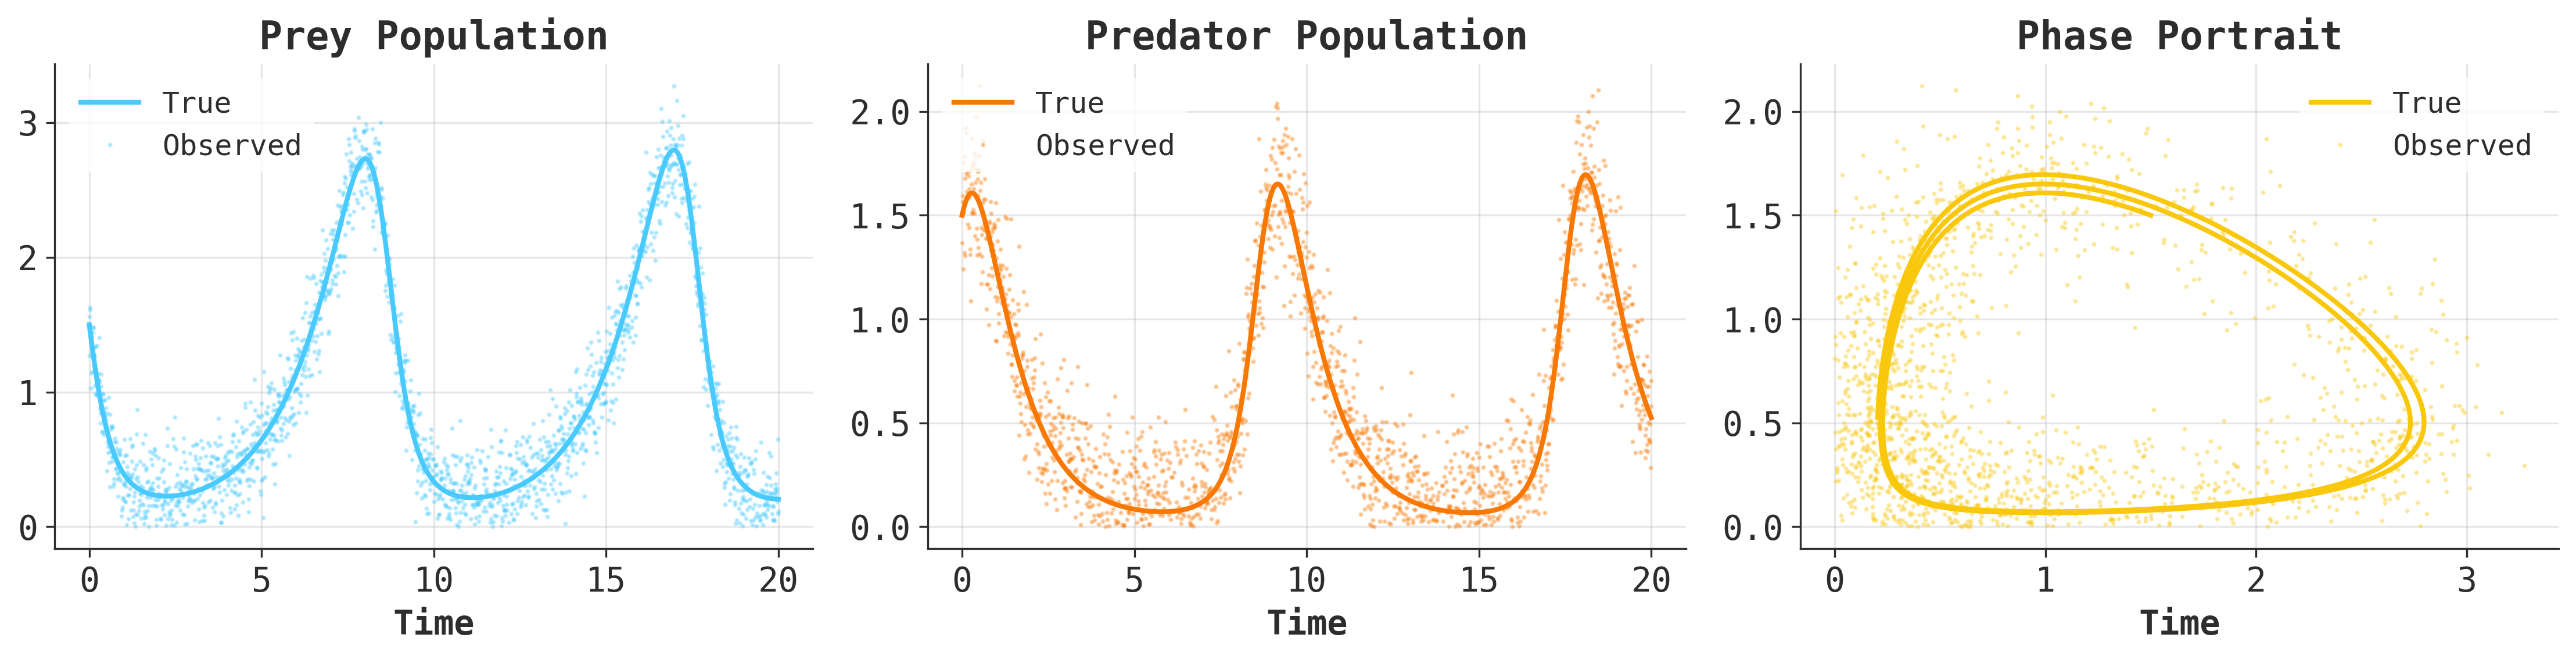

In [11]:
# ... and again, let's make a nice plot. This time,
# we will show both the "deterministic" trajectories and the noisy observations
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(data["time"], data["x_true"], "-", color="C0", linewidth=2, label="True")
mask = data["x_obs"] > 0
axs[0].plot(
    data["time"][mask],
    data["x_obs"][mask],
    "o",
    color="C0",
    alpha=0.3,
    markersize=1,
    label="Observed",
)
axs[0].set_title("Prey Population")


axs[1].plot(data["time"], data["y_true"], "-", color="C1", linewidth=2, label="True")
mask = data["y_obs"] > 0
axs[1].plot(
    data["time"][mask],
    data["y_obs"][mask],
    "o",
    color="C1",
    alpha=0.3,
    markersize=1,
    label="Observed",
)
axs[1].set_title("Predator Population")

axs[2].plot(data["x_true"], data["y_true"], "-", color="C3", linewidth=2, label="True")
mask = (data["x_obs"] > 0) & (data["y_obs"] > 0)
axs[2].plot(
    data["x_obs"][mask],
    data["y_obs"][mask],
    "o",
    color="C3",
    alpha=0.3,
    markersize=1,
    label="Observed",
)
axs[2].set_title("Phase Portrait")

for ax in axs:
    ax.legend()
    ax.set_xlabel("Time")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Numpyro model definition

We now turn to the definition of a numpyro model.
Essentially, we need to define three things:
- The prior distribution over the parameters,
- The evolution of the parameters through the model,
- The variables that we can track in the data.

In our case, the parameters are the Lotka-Volterra parameters,
the evolution is given by the Lotka-Volterra model,
and the variables that we can track are the prey and predator populations.


In [12]:
def create_model(
    x0: float,
    y0: float,
    prior_means: dict,
    prior_std: dict,
    obs_noise_sigma: float,
    n_time_steps: int,
    dt: float,
    observe_every: int | None = None,
):
    """
    Create NumPyro model for Lotka-Volterra inference.

    Key NumPyro concepts:
    - numpyro.sample: declares random variables
    - numpyro.deterministic: deterministic transformations
    - dist.Independent: independence across dimensions

    Note: this is a function that RETURNS A FUNCTION.
    """

    # JIT-compile the ODE solver - this makes the model run faster
    lotka_volterra_jit = jax.jit(partial(lotka_volterra, dt=dt, n_steps=n_time_steps))

    def model(y_obs=None, return_samples=False):
        # Fixed initial conditions - these never change
        x0_det = numpyro.deterministic("x0", x0)
        y0_det = numpyro.deterministic("y0", y0)

        # Log-normal priors (ensures positivity)
        alpha_log = numpyro.sample(
            "alpha_log", dist.Normal(prior_means["alpha_log"], prior_std["alpha_log"])
        )
        beta_log = numpyro.sample(
            "beta_log", dist.Normal(prior_means["beta_log"], prior_std["beta_log"])
        )
        gamma_log = numpyro.sample(
            "gamma_log", dist.Normal(prior_means["gamma_log"], prior_std["gamma_log"])
        )
        delta_log = numpyro.sample(
            "delta_log", dist.Normal(prior_means["delta_log"], prior_std["delta_log"])
        )

        # Transform to natural scale
        alpha = jnp.exp(alpha_log)
        beta = jnp.exp(beta_log)
        gamma = jnp.exp(gamma_log)
        delta = jnp.exp(delta_log)

        # Run the Lotka-Volterra model
        lv_params = LotkaVolterraParams(alpha, beta, gamma, delta)
        x_pred, y_pred = lotka_volterra_jit(x0_det, y0_det, lv_params)

        # Stack into 2D array
        mean = jnp.stack([x_pred, y_pred], axis=0)

        # Likelihood - this is the distribution of the observations
        # We assume that the observations are independent and identically distributed
        lik = dist.Normal(mean, obs_noise_sigma)
        
        # We now define that the quantity y, which is the one we want to track,
        # Is sampled from the likelihood distribution, and during the inference
        # It should be compared to the observations y_obs.
        # dist.Independent(lik, 2) is used to tell numpyro that the likelihood
        # is defined on the 2D array of observations, and not on each element.
        y_sample = numpyro.sample("y", dist.Independent(lik, 2), obs=y_obs)

        if return_samples and y_obs is None:
            return y_sample

    return model


prior_means = {
    "alpha_log": jnp.log(0.8),
    "beta_log": jnp.log(1.2),
    "gamma_log": jnp.log(1.0),
    "delta_log": jnp.log(1.0),
}

prior_std = {"alpha_log": 0.5, "beta_log": 0.5, "gamma_log": 0.5, "delta_log": 0.5}

# Create model
model = create_model(
    x_0, y_0, prior_means, prior_std, obs_noise_sigma, n_time_steps, dt=0.01
)

## Variational Inference with `numpyro`

Once the model is defined, doing the variational inference is straightforward.
We need to define a guide, a distribution over the parameters that we can sample from. We can either define it by ourselves, or use the `AutoGuide` module to automatically infer one.

Then, we need to define a loss function, and an optimizer.

Finally, we can initialize NumPyro's `SVI` object, and train the model.

In [13]:
# Initialize guide parameters near prior means
init_loc = {
    "alpha_log": jnp.log(0.8),
    "beta_log": jnp.log(1.2),
    "gamma_log": jnp.log(1.0),
    "delta_log": jnp.log(1.0),
}

# Define number of epochs
n_epochs = 5_000

# Create guide
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_value(values=init_loc))

# Setup optimizer - optimizers
# can be imported from numpyro.optim or from optax.
optimizer = numpyro.optim.Adam(step_size=0.005)

# Standard ELBO - as we saw in the lecture slides.
loss_fn = Trace_ELBO()

# Create SVI
svi = SVI(model, guide, optimizer, loss=loss_fn)

# Initialize and train
rng_key = jax.random.PRNGKey(42)
svi_state = svi.init(rng_key, y_obs=data["observations"])

losses = []
print("Training SVI...")
# Training loop
pbar = tqdm(range(n_epochs), desc="Training")
for i in pbar:
    svi_state, loss = svi.update(svi_state, y_obs=data["observations"])
    losses.append(loss)
    pbar.set_postfix({"Loss": f"{loss:.4e}"})

# Final loss check
print(f"Final loss: {losses[-1]:.4e}")

Training SVI...


Training: 100%|██████████| 5000/5000 [06:08<00:00, 13.57it/s, Loss=-6.6652e+02]

Final loss: -6.6652e+02


## Analyze results

We can now analyze the results of the training. We will produce five plots, to display:
- The loss trajectory during training,
- The prey population for runs with parameters sampled from the prior, the posterior, and the "untrained" posterior,
- The predator population for runs with parameters sampled from the prior, the posterior, and the "untrained" posterior,
- The phase portrait for runs with parameters sampled from the prior, the posterior, and the "untrained" posterior,
- The priors and posteriors distributions.

FileNotFoundError: [Errno 2] No such file or directory: 'images/image2.png'

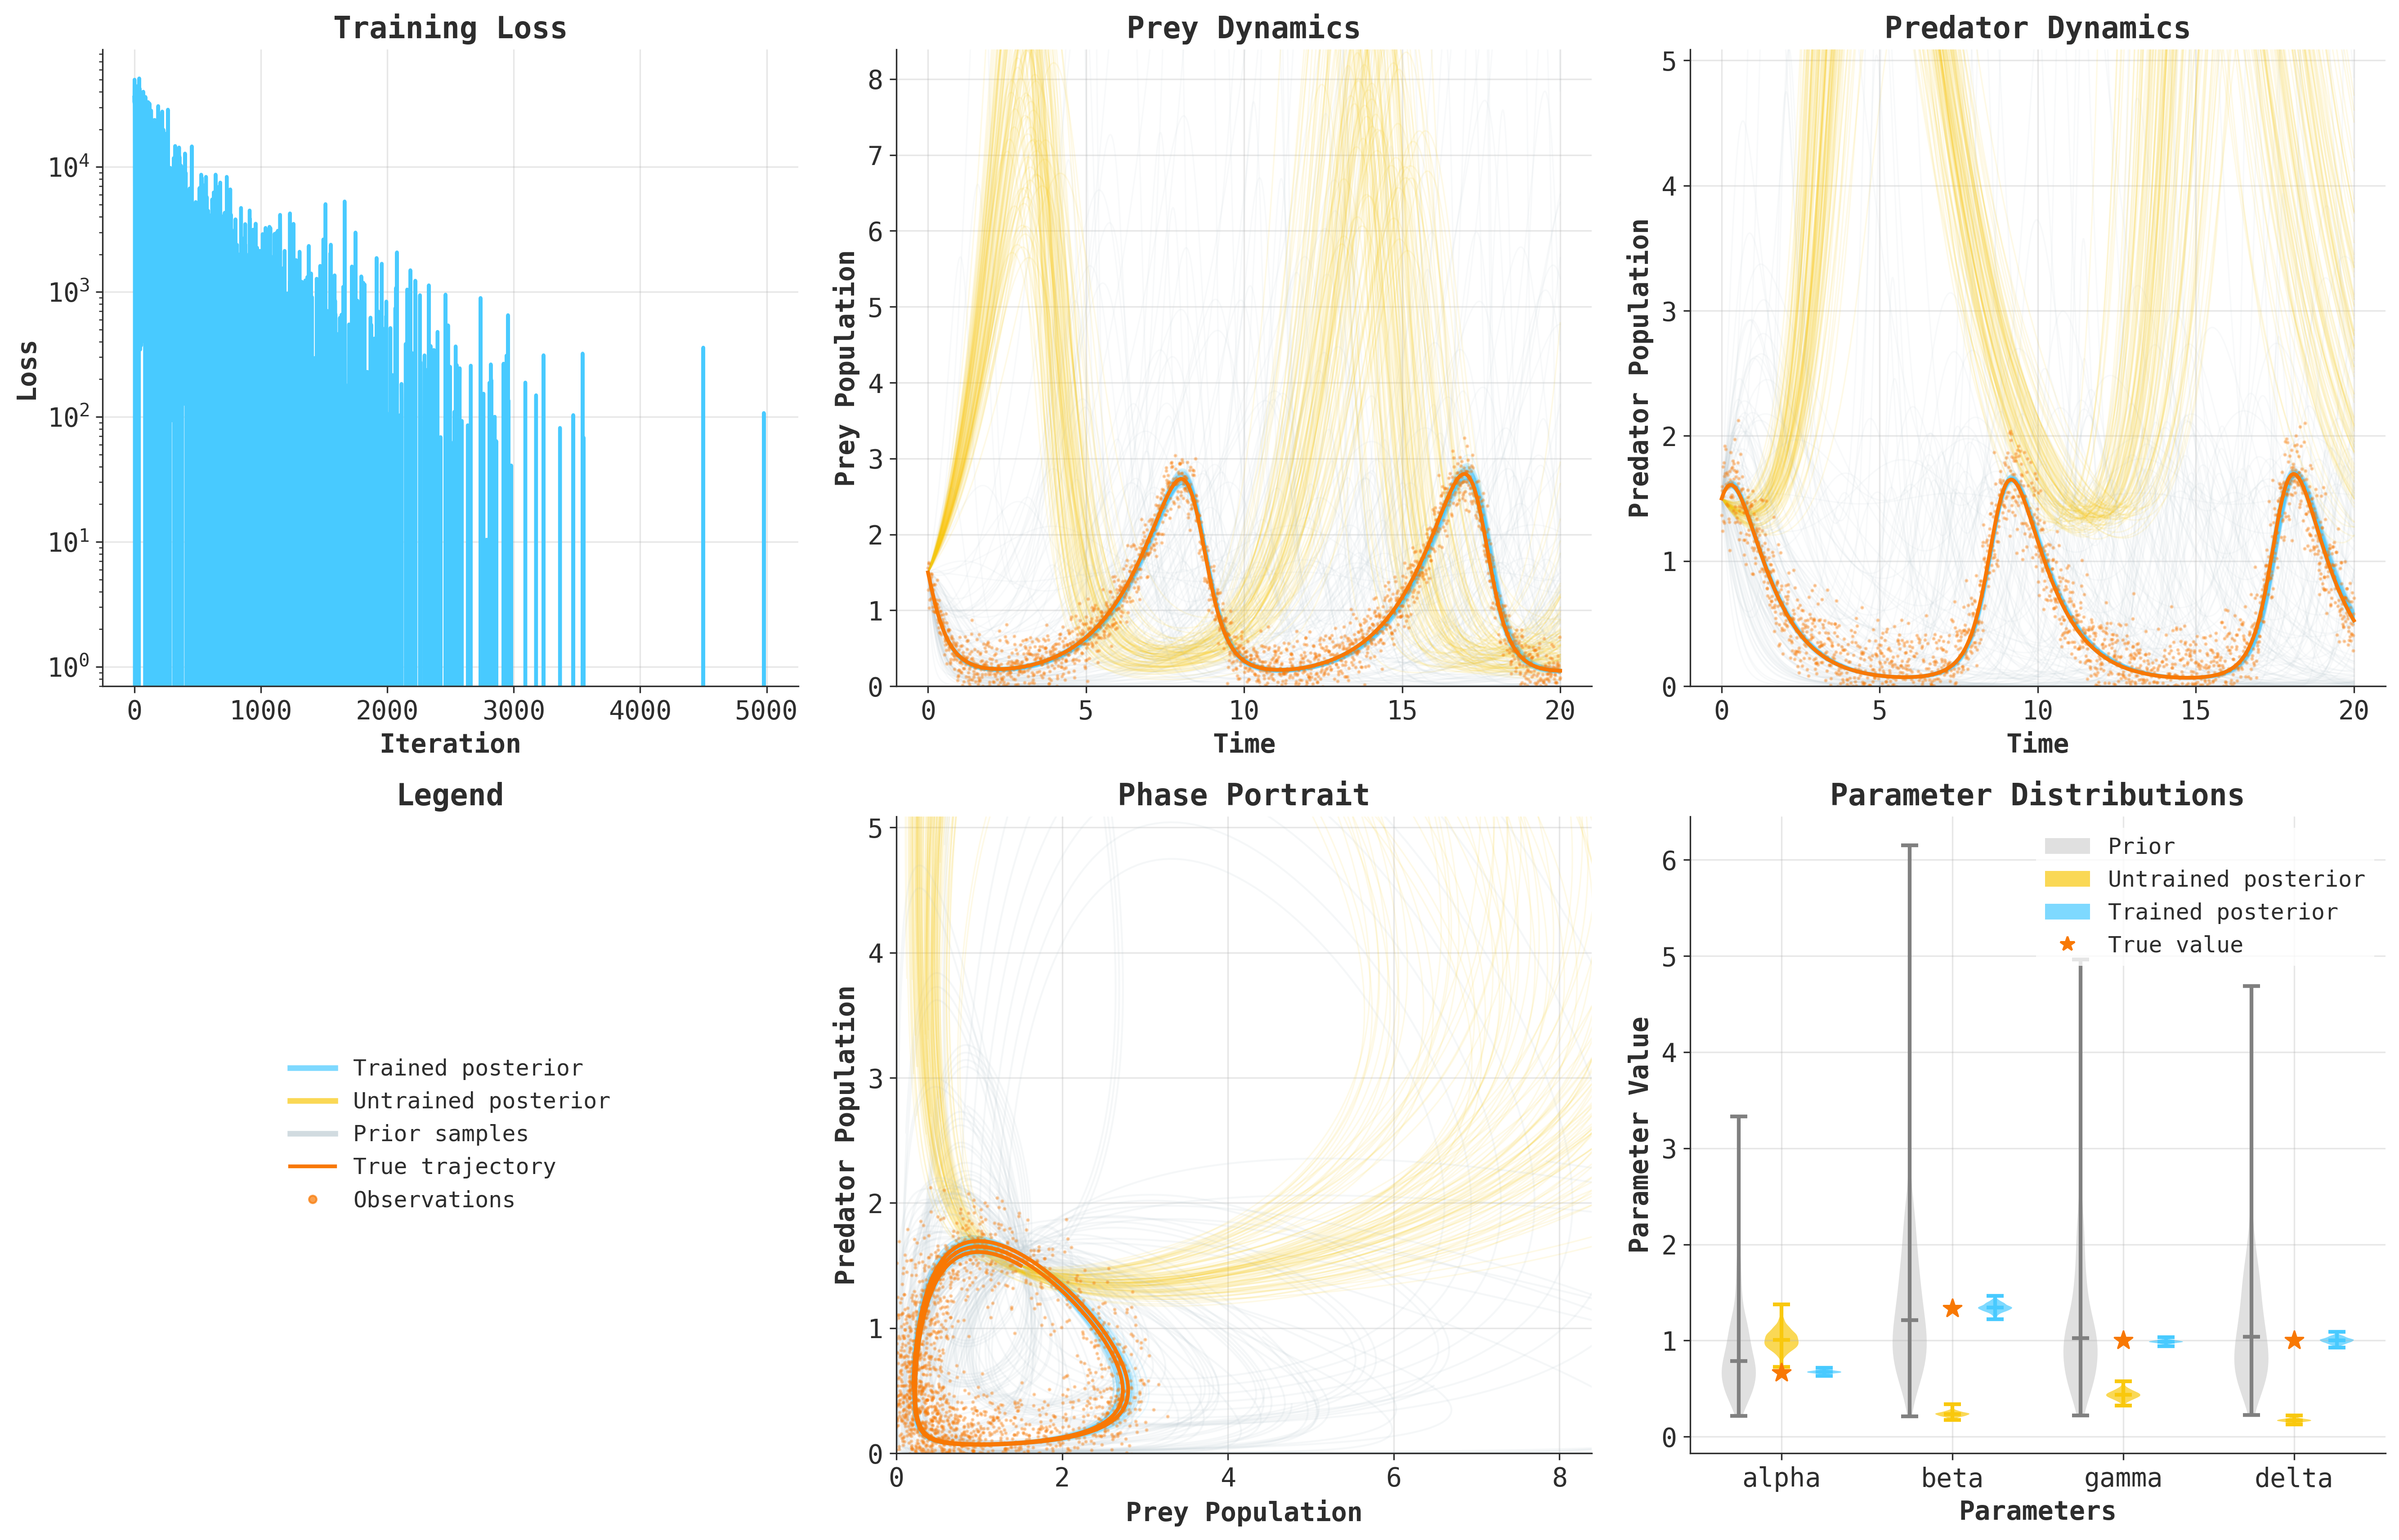

In [14]:
# ==========================================
# Analysis of the trained model
# ==========================================


def produce_model_analysis(
    numpyro_model,
    prior_param_specs,
    optimized_guide,
    svi_trained,
    svi_state_trained,
    training_losses,
    observed_data,
    show_mse=False,
    save_as: str | Path | None = None,
):
    # JIT-compile the model
    lotka_volterra_jit = jax.jit(partial(lotka_volterra, dt=0.01, n_steps=n_time_steps))

    # 1. Trained posterior samples
    params_trained = svi_trained.get_params(svi_state_trained)
    trained_samples = optimized_guide.sample_posterior(
        jax.random.PRNGKey(1), params_trained, sample_shape=(500,)
    )

    # Transform to natural scale
    trained_params = {
        "alpha": jnp.exp(trained_samples["alpha_log"]),
        "beta": jnp.exp(trained_samples["beta_log"]),
        "gamma": jnp.exp(trained_samples["gamma_log"]),
        "delta": jnp.exp(trained_samples["delta_log"]),
    }

    # 2. Untrained posterior samples (baseline comparison)
    guide_untrained = AutoMultivariateNormal(numpyro_model)
    svi_untrained = SVI(
        numpyro_model,
        guide_untrained,
        numpyro.optim.optax_to_numpyro(optax.adam(0.01)),
        loss=Trace_ELBO(),
    )
    svi_state_untrained = svi_untrained.init(
        jax.random.PRNGKey(42), y_obs=observed_data["observations"]
    )
    params_untrained = svi_untrained.get_params(svi_state_untrained)
    untrained_samples = guide_untrained.sample_posterior(
        random.PRNGKey(1), params_untrained, sample_shape=(500,)
    )

    # Transform to natural scale
    untrained_params = {
        "alpha": jnp.exp(untrained_samples["alpha_log"]),
        "beta": jnp.exp(untrained_samples["beta_log"]),
        "gamma": jnp.exp(untrained_samples["gamma_log"]),
        "delta": jnp.exp(untrained_samples["delta_log"]),
    }

    # 3. Prior samples
    rng_key = random.PRNGKey(123)
    prior_samples = {}

    for param_name, log_mean, log_std in prior_param_specs:
        rng_key, subkey = jax.random.split(rng_key)
        log_samples = dist.Normal(log_mean, log_std).sample(subkey, (500,))
        prior_samples[param_name] = jnp.exp(log_samples)

    # ==========================================
    # Create Plots
    # ==========================================

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Color scheme
    colors = {
        "trained": "C0",  # Blue
        "untrained": "C3",  # Red
        "prior": "C2",  # Green
        "true": "C1",  # Orange
        "observed": "C1",
    }

    time = observed_data["time"]
    n_plot = min(100, len(trained_params["alpha"]))

    # Plot 1: Training Loss
    # ----------------------------------------
    training_losses = np.array(training_losses)

    # training_losses_pos = training_losses.copy()
    # training_losses_neg = -1 * training_losses.copy()
    # training_losses_pos[training_losses_pos < 0] = np.nan
    # training_losses_neg[training_losses_neg < 0] = np.nan
    axes[0, 0].plot(training_losses, color=colors["trained"], linewidth=2)
    # axes[0, 0].plot(training_losses_neg, color=colors['untrained'], linewidth=2)
    axes[0, 0].set_xlabel("Iteration")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].set_yscale("log")
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Prey Population Predictions
    # ----------------------------------------
    ax_prey = axes[0, 1]

    for i in range(n_plot):
        # Trained posterior
        lv_params_trained = LotkaVolterraParams(
            trained_params["alpha"][i],
            trained_params["beta"][i],
            trained_params["gamma"][i],
            trained_params["delta"][i],
        )
        x_pred_trained, _ = lotka_volterra_jit(x_0, y_0, lv_params_trained)
        ax_prey.plot(
            time, x_pred_trained, color=colors["trained"], alpha=0.1, linewidth=0.8
        )

        # Untrained posterior
        lv_params_untrained = LotkaVolterraParams(
            untrained_params["alpha"][i],
            untrained_params["beta"][i],
            untrained_params["gamma"][i],
            untrained_params["delta"][i],
        )
        x_pred_untrained, _ = lotka_volterra_jit(x_0, y_0, lv_params_untrained)
        ax_prey.plot(
            time, x_pred_untrained, color=colors["untrained"], alpha=0.1, linewidth=0.8
        )

        # Prior
        lv_params_prior = LotkaVolterraParams(
            prior_samples["alpha"][i],
            prior_samples["beta"][i],
            prior_samples["gamma"][i],
            prior_samples["delta"][i],
        )
        x_pred_prior, _ = lotka_volterra_jit(x_0, y_0, lv_params_prior)
        ax_prey.plot(
            time, x_pred_prior, color=colors["prior"], alpha=0.1, linewidth=0.8
        )

    if show_mse:
        # Compute MSE for untrained, prior and trained
        mse_untrained = jnp.mean((x_pred_untrained - observed_data["x_true"]) ** 2)
        mse_prior = jnp.mean((x_pred_prior - observed_data["x_true"]) ** 2)
        mse_trained = jnp.mean((x_pred_trained - observed_data["x_true"]) ** 2)

        # Show in the plot
        ax_prey.text(
            0.05,
            0.95,
            f"MSE untrained: {mse_untrained:.4f}",
            transform=ax_prey.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )
        ax_prey.text(
            0.05,
            0.90,
            f"MSE prior: {mse_prior:.4f}",
            transform=ax_prey.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )
        ax_prey.text(
            0.05,
            0.85,
            f"MSE trained: {mse_trained:.4f}",
            transform=ax_prey.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )

    # True trajectory and observations
    ax_prey.plot(time, observed_data["x_true"], color=colors["true"], linewidth=2)
    ax_prey.plot(
        time,
        observed_data["x_obs"],
        "o",
        color=colors["observed"],
        alpha=0.3,
        markersize=1,
    )
    ax_prey.set_xlabel("Time")
    ax_prey.set_ylabel("Prey Population")
    ax_prey.set_title("Prey Dynamics")
    ax_prey.set_ylim(0, 3 * jnp.max(observed_data["x_true"]))
    ax_prey.grid(True, alpha=0.3)

    # Plot 3: Predator Population Predictions
    # ----------------------------------------
    ax_predator = axes[0, 2]

    for i in range(n_plot):
        # Trained posterior
        lv_params_trained = LotkaVolterraParams(
            trained_params["alpha"][i],
            trained_params["beta"][i],
            trained_params["gamma"][i],
            trained_params["delta"][i],
        )
        _, y_pred_trained = lotka_volterra_jit(x_0, y_0, lv_params_trained)
        ax_predator.plot(
            time, y_pred_trained, color=colors["trained"], alpha=0.1, linewidth=0.8
        )

        # Untrained posterior
        lv_params_untrained = LotkaVolterraParams(
            untrained_params["alpha"][i],
            untrained_params["beta"][i],
            untrained_params["gamma"][i],
            untrained_params["delta"][i],
        )
        _, y_pred_untrained = lotka_volterra_jit(x_0, y_0, lv_params_untrained)
        ax_predator.plot(
            time, y_pred_untrained, color=colors["untrained"], alpha=0.1, linewidth=0.8
        )

        # Prior
        lv_params_prior = LotkaVolterraParams(
            prior_samples["alpha"][i],
            prior_samples["beta"][i],
            prior_samples["gamma"][i],
            prior_samples["delta"][i],
        )
        _, y_pred_prior = lotka_volterra_jit(x_0, y_0, lv_params_prior)
        ax_predator.plot(
            time, y_pred_prior, color=colors["prior"], alpha=0.1, linewidth=0.8
        )

    if show_mse:
        # Compute MSE for untrained, prior and trained
        mse_untrained = jnp.mean((y_pred_untrained - observed_data["y_true"]) ** 2)
        mse_prior = jnp.mean((y_pred_prior - observed_data["y_true"]) ** 2)
        mse_trained = jnp.mean((y_pred_trained - observed_data["y_true"]) ** 2)

        ax_predator.text(
            0.05,
            0.95,
            f"MSE untrained: {mse_untrained:.4f}",
            transform=ax_predator.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )
        ax_predator.text(
            0.05,
            0.90,
            f"MSE prior: {mse_prior:.4f}",
            transform=ax_predator.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )
        ax_predator.text(
            0.05,
            0.85,
            f"MSE trained: {mse_trained:.4f}",
            transform=ax_predator.transAxes,
            verticalalignment="top",
            horizontalalignment="left",
            fontsize=12,
        )

    # True trajectory and observations
    ax_predator.plot(time, observed_data["y_true"], color=colors["true"], linewidth=2)
    ax_predator.plot(
        time,
        observed_data["y_obs"],
        "o",
        color=colors["observed"],
        alpha=0.3,
        markersize=1,
    )
    ax_predator.set_xlabel("Time")
    ax_predator.set_ylabel("Predator Population")
    ax_predator.set_title("Predator Dynamics")
    ax_predator.set_ylim(0, 3 * jnp.max(observed_data["y_true"]))
    ax_predator.grid(True, alpha=0.3)

    # Plot 4: Phase Portrait
    # ----------------------------------------
    ax_phase = axes[1, 1]
    n_phase = min(50, len(trained_params["alpha"]))

    for i in range(n_phase):
        # Trained posterior
        lv_params_trained = LotkaVolterraParams(
            trained_params["alpha"][i],
            trained_params["beta"][i],
            trained_params["gamma"][i],
            trained_params["delta"][i],
        )
        x_pred_trained, y_pred_trained = lotka_volterra_jit(x_0, y_0, lv_params_trained)
        ax_phase.plot(
            x_pred_trained,
            y_pred_trained,
            color=colors["trained"],
            alpha=0.1,
            linewidth=0.8,
        )

        # Untrained posterior
        lv_params_untrained = LotkaVolterraParams(
            untrained_params["alpha"][i],
            untrained_params["beta"][i],
            untrained_params["gamma"][i],
            untrained_params["delta"][i],
        )
        x_pred_untrained, y_pred_untrained = lotka_volterra_jit(
            x_0, y_0, lv_params_untrained
        )
        ax_phase.plot(
            x_pred_untrained,
            y_pred_untrained,
            color=colors["untrained"],
            alpha=0.1,
            linewidth=0.8,
        )

        # Prior
        lv_params_prior = LotkaVolterraParams(
            prior_samples["alpha"][i],
            prior_samples["beta"][i],
            prior_samples["gamma"][i],
            prior_samples["delta"][i],
        )
        x_pred_prior, y_pred_prior = lotka_volterra_jit(x_0, y_0, lv_params_prior)
        ax_phase.plot(
            x_pred_prior, y_pred_prior, color=colors["prior"], alpha=0.15, linewidth=1.0
        )

    # True trajectory and observations
    ax_phase.plot(
        observed_data["x_true"],
        observed_data["y_true"],
        color=colors["true"],
        linewidth=2,
    )
    ax_phase.plot(
        observed_data["x_obs"],
        observed_data["y_obs"],
        "o",
        color=colors["observed"],
        alpha=0.3,
        markersize=1,
    )
    ax_phase.set_xlabel("Prey Population")
    ax_phase.set_ylabel("Predator Population")
    ax_phase.set_title("Phase Portrait")
    ax_phase.set_xlim(0, 3 * jnp.max(observed_data["x_true"]))
    ax_phase.set_ylim(0, 3 * jnp.max(observed_data["y_true"]))
    ax_phase.grid(True, alpha=0.3)

    # Plot 5: Parameter Distributions
    # ----------------------------------------
    ax_params = axes[1, 2]
    param_names = ["alpha", "beta", "gamma", "delta"]
    x_positions = np.arange(len(param_names))
    width = 0.25

    # Plot violin plots for each parameter
    for i, param in enumerate(param_names):
        # Prior
        vp_prior = ax_params.violinplot(
            [prior_samples[param]],
            positions=[i - width],
            widths=width * 0.8,
            showmeans=False,
            showmedians=True,
        )
        for pc in vp_prior["bodies"]:
            pc.set_facecolor("lightgray")
            pc.set_alpha(0.7)
        # Color whiskers and median lines
        for partname in ("cbars", "cmins", "cmaxes", "cmedians"):
            if partname in vp_prior:
                vp_prior[partname].set_color("gray")

        # Untrained posterior
        vp_untrained = ax_params.violinplot(
            [untrained_params[param]],
            positions=[i],
            widths=width * 0.8,
            showmeans=False,
            showmedians=True,
        )
        for pc in vp_untrained["bodies"]:
            pc.set_facecolor(colors["untrained"])
            pc.set_alpha(0.7)
        # Color whiskers and median lines
        for partname in ("cbars", "cmins", "cmaxes", "cmedians"):
            if partname in vp_untrained:
                vp_untrained[partname].set_color(colors["untrained"])

        # Trained posterior
        vp_trained = ax_params.violinplot(
            [trained_params[param]],
            positions=[i + width],
            widths=width * 0.8,
            showmeans=False,
            showmedians=True,
        )
        for pc in vp_trained["bodies"]:
            pc.set_facecolor(colors["trained"])
            pc.set_alpha(0.7)
        # Color whiskers and median lines
        for partname in ("cbars", "cmins", "cmaxes", "cmedians"):
            if partname in vp_trained:
                vp_trained[partname].set_color(colors["trained"])

        # True value
        ax_params.scatter(
            [i], [true_params[param]], color="C1", s=100, marker="*", zorder=10
        )

    ax_params.set_xticks(x_positions)
    ax_params.set_xticklabels(param_names)
    ax_params.set_xlabel("Parameters")
    ax_params.set_ylabel("Parameter Value")
    ax_params.set_title("Parameter Distributions")
    ax_params.grid(True, alpha=0.3)

    # Custom legend for parameters
    param_legend = [
        Patch(facecolor="lightgray", alpha=0.7, label="Prior"),
        Patch(facecolor=colors["untrained"], alpha=0.7, label="Untrained posterior"),
        Patch(facecolor=colors["trained"], alpha=0.7, label="Trained posterior"),
        plt.Line2D(
            [0],
            [0],
            marker="*",
            color="C1",
            linestyle="None",
            markersize=8,
            label="True value",
        ),
    ]
    ax_params.legend(handles=param_legend, loc="upper right")

    # Plot 6: Legend
    # ----------------------------------------
    legend_handles = [
        plt.Line2D(
            [0],
            [0],
            color=colors["trained"],
            alpha=0.7,
            linewidth=3,
            label="Trained posterior",
        ),
        plt.Line2D(
            [0],
            [0],
            color=colors["untrained"],
            alpha=0.7,
            linewidth=3,
            label="Untrained posterior",
        ),
        plt.Line2D(
            [0],
            [0],
            color=colors["prior"],
            alpha=0.7,
            linewidth=3,
            label="Prior samples",
        ),
        plt.Line2D(
            [0], [0], color=colors["true"], linewidth=2, label="True trajectory"
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=colors["observed"],
            linestyle="None",
            alpha=0.7,
            markersize=4,
            label="Observations",
        ),
    ]
    axes[1, 0].legend(handles=legend_handles, loc="center", fontsize=12)
    axes[1, 0].set_title("Legend")
    axes[1, 0].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    if save_as is not None:
        plt.savefig(save_as, dpi=300)

    plt.show()


param_specs = [
    ("alpha", jnp.log(0.8), 0.5),
    ("beta", jnp.log(1.2), 0.5),
    ("gamma", jnp.log(1.0), 0.5),
    ("delta", jnp.log(1.0), 0.5),
]

save_as = "images/image2.png"
produce_model_analysis(
    numpyro_model=model,
    prior_param_specs=param_specs,
    optimized_guide=guide,
    svi_trained=svi,
    svi_state_trained=svi_state,
    training_losses=losses,
    observed_data=data,
    save_as=save_as,
)